# Datasets comparison between CAMS and TROPOMI (L2)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (NO2, CO, O3, SO2 or HCHO)
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = True

# Define search period
start_date = '2021-11-15'
end_date = '2021-11-16'

# Define extent
lon_min = 1.5
lon_max = 2.5
lat_min = 41
lat_max = 42

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-15T00:00:00Z', '2021-11-15T23:00:00Z'), ('2021-11-16T00:00:00Z', '2021-11-16T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 41 to 42
Longitudes: from 1.5 to 2.5


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple',
                                               CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 3, longitude: 3, step: 8, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-15 2021-11-16
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 41.2 41.6 42.0
  * longitude   (longitude) float64 1.6 2.0 2.4
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-13T20:06 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The columns above each CAMS half level will be calculated.
The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [11]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single',
                                               CAMS_UID = None, CAMS_key = None)
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox, sensor, component_nom, 
                        sensor_type, subset_type = 'model_subset')
model_total_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 3, longitude: 3, step: 8, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-11-15 2021-11-16
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 41.2 41.6 42.0
  * longitude   (longitude) float64 1.6 2.0 2.4
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-13T20:07 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [12]:
model_total_ds, _ = model_convert_units(model, model_total_ds, sensor,
                                        component_mol_weight, component, model_levels_df,
                                        start_date, end_date, component_nom, apply_kernels,
                                        CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [13]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-15T00:00:00Z', '2021-11-15T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-13 20:07:42,728 INFO Found 2 products


Number 0-S5P_NRTI_L2__NO2____20211115T132216_20211115T132716_21198_02_020200_20211115T140523
Number 1-S5P_NRTI_L2__NO2____20211115T114216_20211115T114716_21197_02_020200_20211115T122916
SELECTED
File name: d6a7e748-c65e-4e8e-84fb-bb44f2b99b7c
Product name: S5P_NRTI_L2__NO2____20211115T132216_20211115T132716_21198_02_020200_20211115T140523.nc
The file exists, it will not be downloaded again.
For ('2021-11-16T00:00:00Z', '2021-11-16T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-13 20:07:53,332 INFO Found 1 products


Number 0-S5P_NRTI_L2__NO2____20211116T130216_20211116T130716_21212_02_020200_20211116T134652
SELECTED
File name: 85ab7ebc-82b4-4bd7-8442-9238d918053f
Product name: S5P_NRTI_L2__NO2____20211116T130216_20211116T130716_21212_02_020200_20211116T134652.nc
The file exists, it will not be downloaded again.


In [14]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

In [15]:
support_input_ds

<xarray.Dataset>
Dimensions:                                (ground_pixel: 450, scanline: 373, time: 2)
Coordinates:
  * time                                   (time) datetime64[ns] 2021-11-15 2...
  * scanline                               (scanline) float64 0.0 1.0 ... 372.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/18)
    surface_altitude                       (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision             (time, scanline, ground_pixel) float32 ...
    surface_classification                 (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier    (time, scanline) float64 14.0 ... ...
    instrument_configuration_version       (time, scanline) float32 16.0 ... ...
    scaled_small_pixel_variance            (time, scanline, ground_pixel) float32 ...
    ...                                     ...
    cloud_fraction_crb                     (time, scanline, ground_pixel) float32 ...
    cloud_albedo_crb                       (time, scanline, ground_pixel) float32 ...
    scene_albedo                           (time, scanline, ground_pixel) float32 ...
    apparent_scene_pressure                (time, scanline, ground_pixel) float32 ...
    snow_ice_flag                          (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388                  (time, scanline, ground_pixel) float32 ...

In [16]:
support_details_ds

<xarray.Dataset>
Dimensions:                                                (ground_pixel: 450, intensity_offset_polynomial_exponents: 1, polynomial_exponents: 6, scanline: 373, time: 2)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
  * scanline                                               (scanline) float64 ...
  * ground_pixel                                           (ground_pixel) float64 ...
Dimensions without coordinates: intensity_offset_polynomial_exponents, polynomial_exponents
Data variables: (12/45)
    processing_quality_flags                               (time, scanline, ground_pixel) float64 ...
    number_of_spectral_points_in_retrieval                 (time, scanline, ground_pixel) float32 ...
    number_of_iterations                                   (time, scanline, ground_pixel) float64 ...
    wavelength_calibration_offset                          (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_offset_precision                (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_stretch                         (time, scanline, ground_pixel) float32 ...
    ...                                                     ...
    degrees_of_freedom                                     (time, scanline, ground_pixel) float32 ...
    air_mass_factor_stratosphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_cloudy                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_clear                                  (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_ghost_column                           (time, scanline, ground_pixel) float32 ...
    cloud_selection_flag                                   (time, scanline, ground_pixel) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [17]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [18]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

APPLICATION OF AVERAGING KERNELS
For the application of the averaging kernels, it is necessary to calculate:
1. Level pressures
2. Column kernels
The apriori profiles should be retrieved, but they are not necessary.
DATA AVAILABILITY
The level pressures will be calculated.
The column kernels will be calculated.
The dataset does not contain any apriori profile.
FOR DATE: 2021-11-15
FOR DATE: 2021-11-16


pressure   index  \
time       ground_pixel scanline layer                          
2021-11-15 375.0        273.0    0.0    100370.765625       0   
                                 1.0     99046.992188       2   
                                 2.0     96701.265625       4   
                                 3.0     93202.015625       6   
                                 4.0     88178.367188       8   
...                                               ...     ...   
2021-11-16 321.0        370.0    29.0      625.780151  112054   
                                 30.0      309.465515  112056   
                                 31.0      130.429565  112058   
                                 32.0       44.064754  112060   
                                 33.0        9.304465  112062   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-15 375.0        273.0    0.0   2021-11-15 13:25:59.817  40.976803   
                                 1.0   2021-11-15 13:25:59.817  40.976803   
                                 2.0   2021-11-15 13:25:59.817  40.976803   
                                 3.0   2021-11-15 13:25:59.817  40.976803   
                                 4.0   2021-11-15 13:25:59.817  40.976803   
...                                                        ...        ...   
2021-11-16 321.0        370.0    29.0  2021-11-16 13:07:21.547  42.096088   
                                 30.0  2021-11-16 13:07:21.547  42.096088   
                                 31.0  2021-11-16 13:07:21.547  42.096088   
                                 32.0  2021-11-16 13:07:21.547  42.096088   
                                 33.0  2021-11-16 13:07:21.547  42.096088   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-15 375.0        273.0    0.0     1.541311      1.00   2.425610e+15   
                                 1.0     1.541311      1.00   2.425610e+15   
                                 2.0     1.541311      1.00   2.425610e+15   
                                 3.0     1.541311      1.00   2.425610e+15   
                                 4.0     1.541311      1.00   2.425610e+15   
...                                           ...       ...            ...   
2021-11-16 321.0        370.0    29.0    2.470238      0.74   9.411831e+14   
                                 30.0    2.470238      0.74   9.411831e+14   
                                 31.0    2.470238      0.74   9.411831e+14   
                                 32.0    2.470238      0.74   9.411831e+14   
                                 33.0    2.470238      0.74   9.411831e+14   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-15 375.0        273.0    0.0                                         0.000013   
                                 1.0                                         0.000013   
                                 2.0                                         0.000013   
                                 3.0                                         0.000013   
                                 4.0                                         0.000013   
...                                                                               ...   
2021-11-16 321.0        370.0    29.0                                        0.000017   
                                 30.0                                        0.000017   
                                 31.0                                        0.000017   
                                 32.0                                        0.000017   
                                 33.0                                        0.000017   

                        

## 5. Merge data and calculate difference

In [19]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

,,,latitude,longitude,model_column,sensor_column,difference,relative_difference
scanline,ground_pixel,time,,,,,,
273.0,375.0,2021-11-15,40.976803,1.541311,NaN,2.425610e+15,NaN,NaN
274.0,375.0,2021-11-15,41.025761,1.530660,1.860702e+15,1.786660e+15,7.404281e+13,0.041442
275.0,375.0,2021-11-15,41.074738,1.520018,2.112371e+15,2.376777e+15,-2.644063e+14,-0.111246
276.0,375.0,2021-11-15,41.123718,1.509346,2.130975e+15,2.558412e+15,-4.274369e+14,-0.167071
277.0,375.0,2021-11-15,41.172672,1.498640,2.348929e+15,2.234778e+15,1.141516e+14,0.051080
...,...,...,...,...,...,...,...,...
366.0,321.0,2021-11-16,41.900219,2.524499,1.342656e+15,1.366029e+15,-2.337344e+13,-0.017110
367.0,321.0,2021-11-16,41.949188,2.510918,1.379523e+15,2.493631e+15,-1.114109e+15,-0.446782
368.0,321.0,2021-11-16,41.998158,2.497374,1.398349e+15,7.756659e+13,1.320782e+15,17.027721


In [20]:
descr_statistics_table = merge_df.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference,relative_difference
count,844.000000,844.000000,8.340000e+02,8.360000e+02,8.340000e+02,834.000000
mean,41.503810,1.985023,1.833023e+15,2.398863e+15,-5.652560e+14,-0.020027
std,0.308150,0.368330,4.006467e+14,1.484153e+15,1.466990e+15,9.451767
min,40.930744,1.237029,9.492891e+14,-1.253343e+15,-6.498081e+15,-108.064571
25%,41.239793,1.675739,1.490185e+15,1.660368e+15,-1.410849e+15,-0.489767
50%,41.500696,1.980052,1.813351e+15,2.335513e+15,-6.113208e+14,-0.323648
75%,41.769119,2.292239,2.113343e+15,3.195269e+15,3.516374e+14,-0.004934
max,42.096088,2.752607,2.861969e+15,8.446380e+15,3.481564e+15,171.552394


## 6. Show comparison plots

### Select plot dates

In [21]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2021-11-15' '2021-11-16']


### Select plot extent

In [22]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((1.5, 41), (2.5, 42))


### Compare CAMS and TROPOMI total columns

In [23]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'animated'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

2021-12-13 20:30:49,727 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


2021-12-13 20:30:51,752 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-12-13 20:30:51,754 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x720 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y animation.gif


### Compare CAMS original and averaged total columns

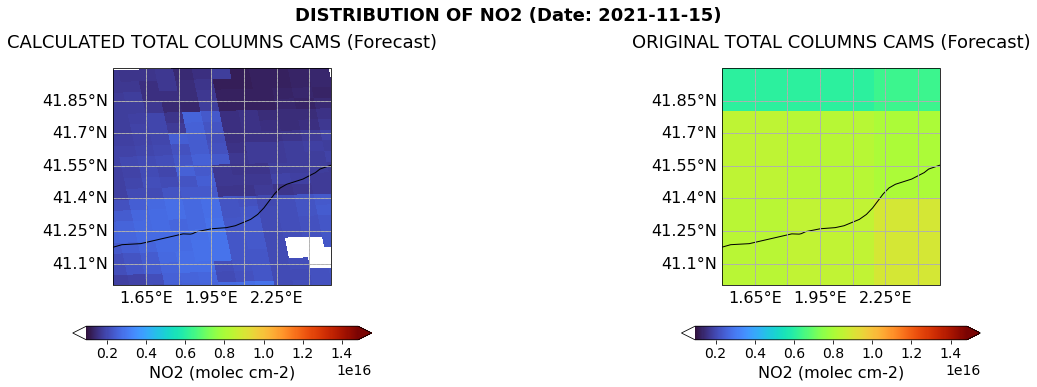

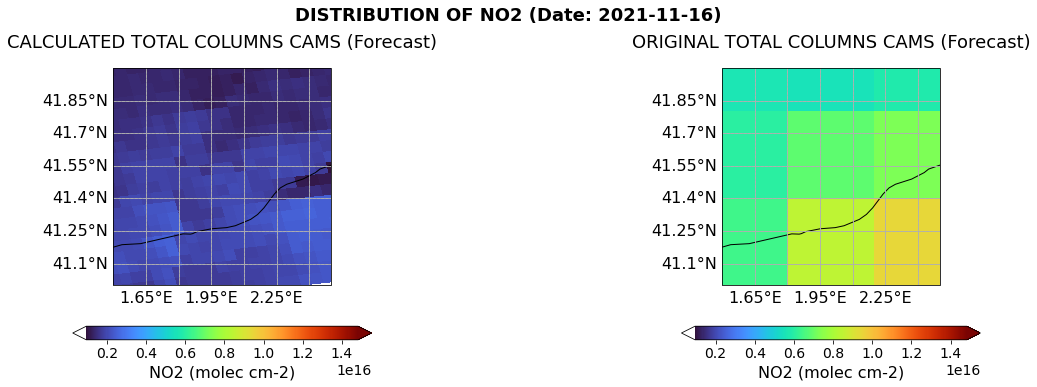

In [24]:
# Choose distribution (individual)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_df, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1.05, model_type, range_type, projection, color_scale,
                                       vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

scanline  ground_pixel  \
lat_search lon_search latitude  longitude time                                 
41.39      2.15       41.390068 2.118585  2021-11-15     281.0         383.0   
                      41.409931 2.171800  2021-11-16     357.0         312.0   
41.10      1.65       41.129585 1.669390  2021-11-15     276.0         377.0   
                      41.095612 1.641320  2021-11-16     352.0         300.0   

                                                      model_column  \
lat_search lon_search latitude  longitude time                       
41.39      2.15       41.390068 2.118585  2021-11-15  2.160767e+15   
                      41.409931 2.171800  2021-11-16  1.922813e+15   
41.10      1.65       41.129585 1.669390  2021-11-15  2.371324e+15   
                      41.095612 1.641320  2021-11-16  1.932274e+15   

                                                      sensor_column  \
lat_search lon_search latitude  longitude time                        
41.39      2.15       41.390068 2.118585  2021-11-15   1.252238e+13   
                      41.409931 2.171800  2021-11-16   4.619110e+15   
41.10      1.65       41.129585 1.669390  2021-11-15   2.983563e+15   
                      41.095612 1.641320  2021-11-16   2.525397e+15   

                                                        difference  \
lat_search lon_search latitude  longitude time                       
41.39      2.15       41.390068 2.118585  2021-11-15  2.148244e+15   
                      41.409931 2.171800  2021-11-16 -2.696297e+15   
41.10      1.65       41.129585 1.669390  2021-11-15 -6.122394e+14   
                      41.095612 1.641320  2021-11-16 -5.931224e+14   

                                                      relative_difference  
lat_search lon_search latitude  longitude time                             
41.39      2.15       41.390068 2.118585  2021-11-15           171.552394  
                      41.409931 2.171800  2021-11-16            -0.583727  
41.10      1.65       41.129585 1.669390  2021-11-15            -0.205204  
                      41.095612 1.641320  2021-11-16            -0.234863

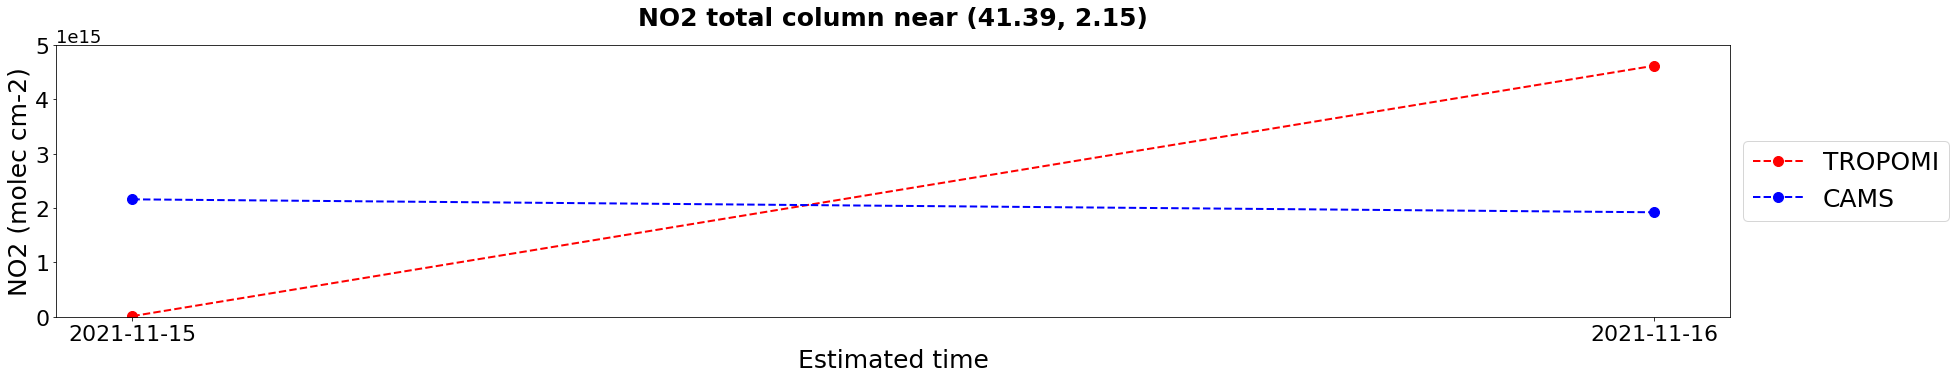

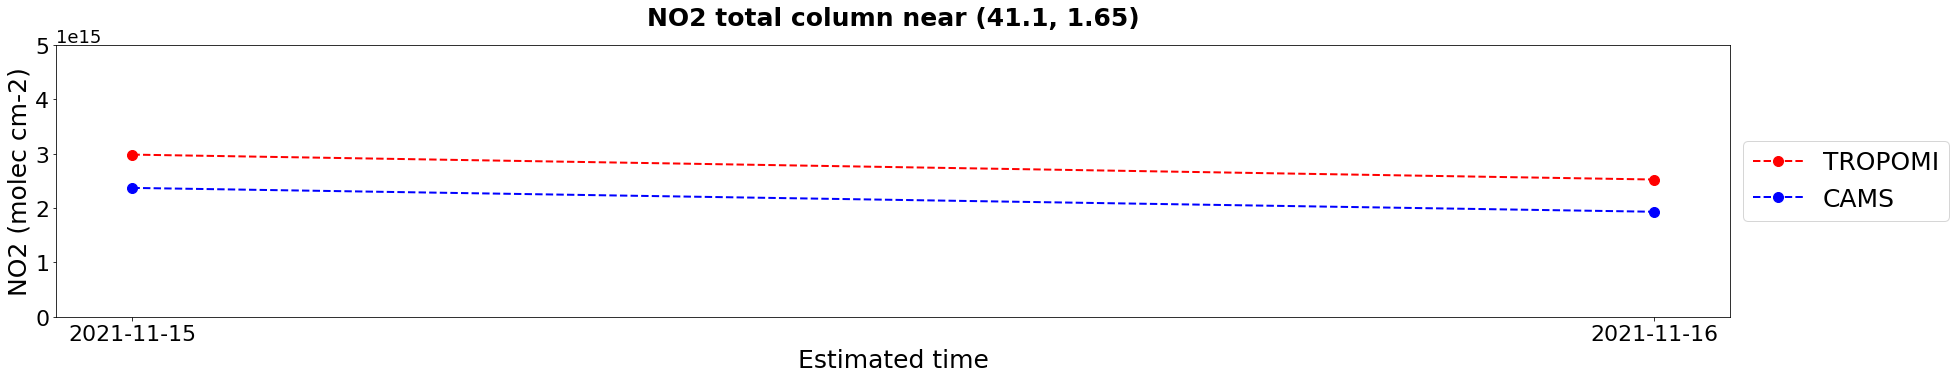

In [25]:
coords_search_list = (41.39, 2.15,
                      41.1, 1.65)
ymin = 0
ymax = 5*10**15
xticks = plot_dates
retrieval_table_all =  retrieve_coords(merge_df.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units, ymin, ymax, xticks)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.16 + (1.82E+15)
Coefficient of determination (R2): 0.16


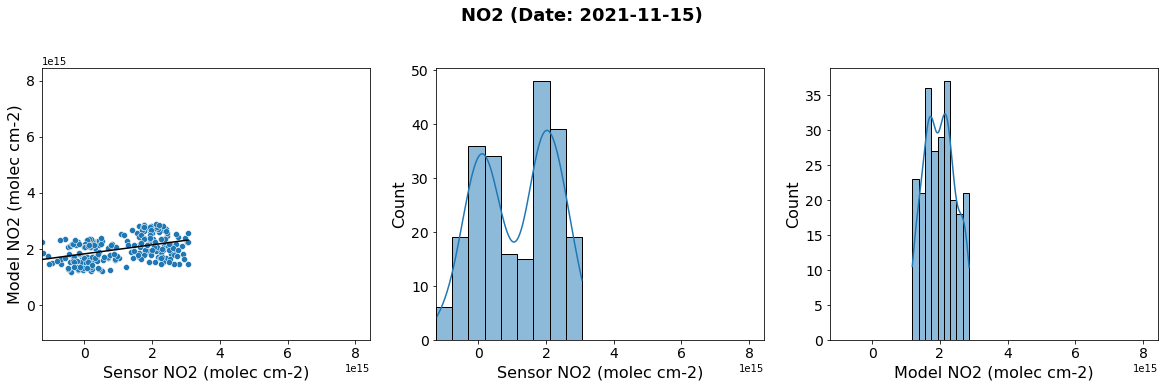

Fit equation: NO2_model = NO2_sensor * 0.13 + (1.37E+15)
Coefficient of determination (R2): 0.26


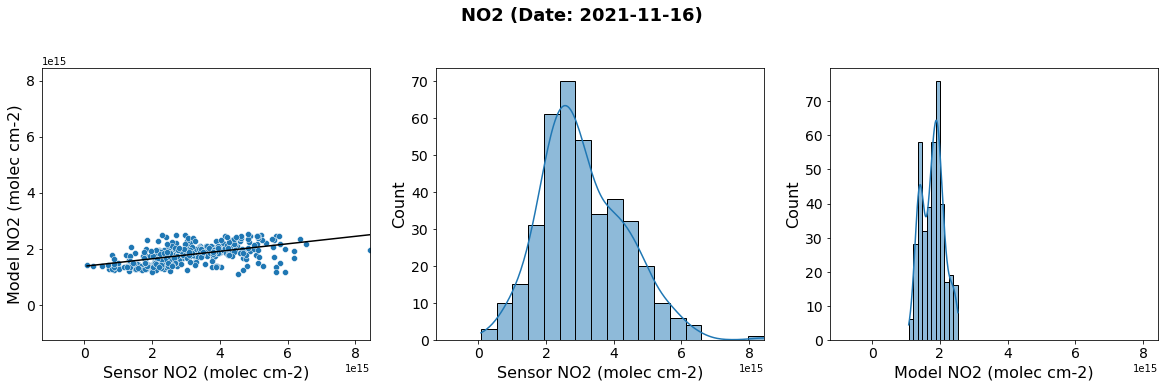

In [26]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [27]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2021-11-15,"((1.5, 41), (2.5, 42))",0.162856,0.160519,1.815301e+15
1,2021-11-16,"((1.5, 41), (2.5, 42))",0.258150,0.133276,1.372524e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.05 + (1.76E+15)
Coefficient of determination (R2): 0.03


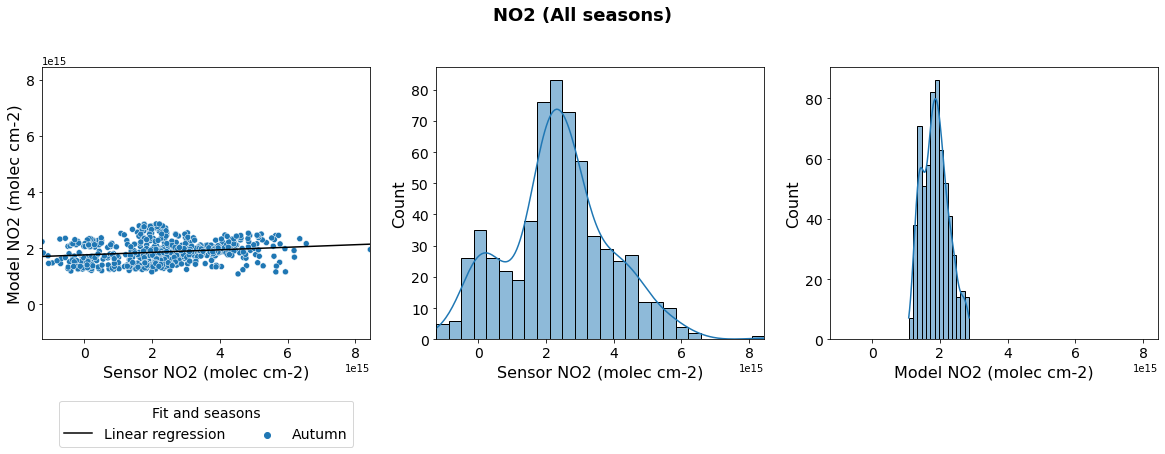

In [28]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [29]:
summary

,Period,Location,Score,Coefficient,Intercept
0,[Autumn],"((1.5, 41), (2.5, 42))",0.031823,0.045335,1.757278e+15


## 10. Scatter plots by country (Google API required!)

In [30]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [31]:
#summary